# Assignment 3 AML

In [3]:
import pandas as pd
import numpy as np
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.utils import resample


# 1. Preprocessing

### Step 1: Assign single label to each comment 

In [6]:
#Reading of the training data
training_data = pd.read_csv('a3_train_final.tsv', sep='\t', header=None)

print(f'The total amount of comments are {len(training_data)}.')

#Split the data into covariate (comment) and response (labels)
X_train = training_data.iloc[:,1]
y_labels = training_data[0].str.split('/')

y_train = []
disagreements = 0
unsolved_disagreements = 0
oringinal_label_unknown = 0

#For each label we define a Counter object that gives an overview about
#all annotations. If we have more than a single annotation we evaluate
#if they agree, have a majority, have a majority for unclear opinion
#or are undecided. The goal is to set the label for all problematic cases 
#to -1 for easy removal in the next step. 
for labels in y_labels:
    c = Counter(labels)
    if len(c) > 1:
        disagreements += 1
        if c.most_common()[0][1] == c.most_common()[1][1]:
            unsolved_disagreements += 1
            label = -1
        else:
            if c.most_common()[0][0] == '-1':
                oringinal_label_unknown += 1
            label = c.most_common()[0][0]
    else:
        if labels[0] == '-1':
            oringinal_label_unknown += 1
        label = labels[0]
    y_train.append(label)

print(f'The number of annotations with conflicting labels is {disagreements}.')
print(f'Thereof conflicts we cannot resolve by a majority are {unsolved_disagreements}.')
print(f'Annotators agreed that the opinion was unclear in {oringinal_label_unknown} cases.')

y_train = np.array(y_train).astype(int)

y_train


The total amount of comments are 11596.
The number of annotations with conflicting labels is 2001.
Thereof conflicts we cannot resolve by a majority are 1838.
Annotators agreed that the opinion was unclear in 8 cases.


array([ 0, -1,  0, ...,  0,  0, -1])

In [7]:
#Reading the test data
X_test = pd.read_csv('a3_test.tsv', sep='\t', header=None)
y_test = X_test.pop(0)

#Making sure that X_test in a Series object as it only consists of a single column 
X_test = X_test[1]

### Step 2: Kick out all unclear comments

In [9]:
#Filtering for comments where annotators agreed on the commenters opinion. 
X_train = X_train[y_train != -1]
y_train = y_train[y_train != -1]

#Transform the data by using the TF-IDF vectorizer. 
vec = TfidfVectorizer()
X_train_trans = vec.fit_transform(X_train)
X_test_trans = vec.transform(X_test)

In [15]:
#Sample for evaluation of Random Forest Parameters. Reducing computational time. 
X_train_trans_sample, y_train_sample = resample(X_train_trans, y_train, n_samples=1000, random_state=0)

# 2. Component Models

### Random Forest

In [ ]:
#The parameters we want to evaluate are the maximum depth and the criterion to define the best split.   
param_grid = {
    'max_depth': range(10,21),
    'criterion': ['gini', 'log_loss', 'entropy']
}

#This is the classifier with all prior agreed parameters. 
rfcf = RandomForestClassifier(n_estimators=100, n_jobs= -1, random_state=0)

#Echaustive search over all parameter combinations
gs = GridSearchCV(param_grid=param_grid, cv = 5, scoring='accuracy', estimator=rfcf)
gs.fit(X_train_trans_sample, y_train_sample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'criterion': ['gini', 'log_loss', 'entropy'],
                         'max_depth': range(10, 21)},
             scoring='accuracy')

In [22]:
#This is the optimal model
rfcf_opt = gs.best_estimator_
print(f'The best results are optained by chosing {gs.best_params_}.')

print(f'The cross-validation score on the training data is {cross_val_score(rfcf_opt, X_train_trans, y_train).mean()}.')

The best results are optained by chosing {'criterion': 'gini', 'max_depth': 18}.
The cross-validation score on the training data is 0.7335384615384615.


### Gradient Boost

In [2]:
# Define the objective function
def objective(trial):
    params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1]),
        "max_depth": trial.suggest_categorical("max_depth", [3, 5, 7, 9, 10]),
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 150, 200, 250, 300]),
        "subsample": trial.suggest_categorical("subsample", [0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        "gamma": trial.suggest_categorical("gamma", [0, 0.1, 0.5, 1, 2, 5, 10, 15]),
        "reg_alpha": trial.suggest_categorical("reg_alpha", [1, 3, 5, 7, 9, 11, 13, 15]),  # L1 regularization
        "reg_lambda": trial.suggest_categorical("reg_lambda", [1, 3, 5, 7, 9, 11, 13, 15]),  # L2 regularization
    }

    # Train XGBoost model with current parameters
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss")
    
    # Cross-validation to get accuracy
    accuracy = cross_val_score(model, X_train_trans, y_train, cv=5, scoring="accuracy", n_jobs=-1).mean()
    
    return -accuracy  # Minimize the negative accuracy

# Run Optuna study with your parameter list
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # You can increase n_trials for better results

# Print the best hyperparameters
print("Best parameters:", study.best_params)
print(f"Best cross-validation accuracy: {-study.best_value:.2%}")

[I 2025-02-21 20:52:09,648] A new study created in memory with name: no-name-240eec11-af45-47fe-b64b-7582bfb869bc
[W 2025-02-21 20:52:09,656] Trial 0 failed with parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 1, 'gamma': 10, 'reg_alpha': 3, 'reg_lambda': 5} because of the following error: NameError("name 'xgb' is not defined").
Traceback (most recent call last):
  File "c:\Users\ASUS Vivobook\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_33544\2192508178.py", line 15, in objective
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss")
            ^^^
NameError: name 'xgb' is not defined
[W 2025-02-21 20:52:09,661] Trial 0 failed with value None.


NameError: name 'xgb' is not defined

### Logistic Regression

# 3. Full Model

In [ ]:
#The ensemble of the three models
ensemble = [
    ('rfcf', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=18 ,n_jobs=-1, random_state=0)),
    ('gbcf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.3, max_depth=9, max_features=0.8, random_state=0)), #Input other xBoost model
    ('lr', LogisticRegression(C=0.9, solver='saga', max_iter=1000))
]

#We define our voting classifier on the ensemble
vcf = VotingClassifier(ensemble)
vcf.fit(X_train_trans, y_train)

#We predict test and train set for error analysis and final evaluation
y_pred_train = vcf.predict(X_train_trans)
y_pred_test = vcf.predict(X_test_trans)
y_pred_test = y_pred_test.astype(int)

print(f'The accuracy of the three model Voting classifier is {accuracy_score(y_pred_test, y_test)}.')

The accuracy of the three model Voting classifier is 0.8277153558052435.


# 4. Error Analysis

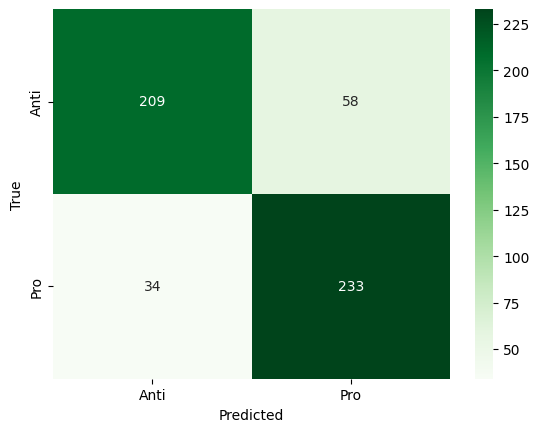

In [ ]:
#Define the Confusion Matrix and plot it 
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Anti", "Pro"], yticklabels=["Anti", "Pro"])

ax.set_xlabel('Predicted')
ax.set_ylabel('True')

#plt.savefig('confusion_matrix_final_model.png')

In [25]:
#Define a new Data Frame that combines the comment, predicted and true label
X_train_results = pd.DataFrame({
    'Comment' : X_train,
    'true_label': y_train,
    'pred_label': y_pred_train
})

#Filter for only those comments where we predicted wrong. 
wrong_class_comments = X_train_results[~(X_train_results['true_label'] == X_train_results['pred_label'])]

#Printing the first twenty comments. 
for i in range(20):
    print(f'{wrong_class_comments.iat[i,0]} \n was wrongly labeled as {wrong_class_comments.iat[i,2]}.')

Benefits outweigh the risks. Yes, the benefits of not getting shot outweigh the risks of getting it. 
 was wrongly labeled as 1.
Covid vaccines are the great accelerator of our time. It speeds up the aging process, bringing about disability that would have taken decades to develop in a matter of years or even months. Now the U.S. is drowning in disability. 
 was wrongly labeled as 1.
Don't tell me what to do with my body - the same people that want to enforce anti-abortion laws on women. 
 was wrongly labeled as 0.
I don't vac let nature take its course If nature took its course you should not exist 
 was wrongly labeled as 0.
I don't want a poison in my body but stuff themselves full of fast food. Crazy. 
 was wrongly labeled as 0.
I don't want to poison my body Gets McDonald's on the way home and gets drunk on the weekend, maybe a few cigarettes too 
 was wrongly labeled as 0.
I lost a relative to COVID. If a simple shot can prevent that, why wouldn’t you take it? 
 was wrongly label